<a href="https://colab.research.google.com/github/LIONPANJSHIR/QSAR-Biodegradations/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## 🧬 Introduction : Modélisation QSAR de la Biodégradation

###  Contexte du Projet

Ce notebook est consacré à l'analyse et à la modélisation prédictive des propriétés de biodégradation de molécules chimiques, en utilisant la célèbre base de données **QSAR Biodegradation** (Quantitative Structure-Activity Relationship), publiée sur l'UCI Machine Learning Repository le 20 juin 2013 par Mansouri, Ringsted et al.

###  Le Problème QSAR

Le modèle de **Relation Quantitative Structure-Activité (QSAR)** est un outil essentiel en chimie et en toxicologie. Il cherche à établir une relation mathématique entre la structure chimique des molécules (représentée par des descripteurs numériques) et une activité biologique ou toxicologique spécifique.

Dans ce contexte, notre objectif est de construire un modèle de **classification binaire** pour prédire si une molécule est :

1.  **Rapidement Biodégradable** (`RB`)
2.  **Lentement Biodégradable** (`NRB` - Not Ready Biodegradable)

###  Structure des Données

Le jeu de données se compose d'une série de **descripteurs moléculaires** (un ensemble de 41 caractéristiques numériques) et de l'étiquette de classification binaire associée.

| Élément | Description |
| :--- | :--- |
| **Caractéristiques (X)** | 41 descripteurs moléculaires (e.g., poids, indices de connectivité, propriétés électroniques) |
| **Cible (y)** | Classification binaire : Rapidement Biodégradable (RB) ou Lentement Biodégradable (NRB) |

###  Objectifs du Notebook

Ce projet a pour ambition de :

1.  Mener une **Analyse Exploratoire (EDA)** pour comprendre la distribution des descripteurs.
2.  Établir un pipeline de **Machine Learning** robuste, en évaluant plusieurs modèles (Arbres, Forêts, SVM, etc.).
3.  Optimiser les modèles pour maximiser les performances sur des métriques clés (précision, rappel, **F1-score**).
4.  Fournir une **interprétation** des résultats pour identifier les descripteurs moléculaires les plus influents sur la biodégradation.



In [1]:
# # 1. Résumé exécutif
# **Objectif.** Prédire la biodégradabilité (RB vs NRB) à partir de 41 descripteurs QSAR (tabulaire).
# **Résultats.** Modèle [XGBoost/RandomForest/LogReg] atteint **ROC-AUC = …**, **Recall(RB) = …**.
# **Impact.** Outil d’aide à l’évaluation environnementale des molécules.

# # 2. Données & protocole
# - **Source.** UCI QSAR Biodegradation (20/06/2013), 1 055 échantillons, 41 features, cible binaire (RB/NRB).
# - **Prétraitement.** Encodage cible (`RB=1`, `NRB=0`), standardisation des features, imputation si besoin.
# - **Split.** Train/Test stratifié (80/20), CV 5-fold, seed=42.
# - **Coût d’erreur.** Favoriser le **recall RB** (réduire les faux négatifs).

# # 3. Méthodes
# - **Baselines.** DummyClassifier, Logistic Regression (ℓ2).
# - **Modèles.** RandomForest, XGBoost/CatBoost (tabulaire), Calibration Platt.
# - **Validation.** CV 5-fold, grid/random/Optuna; métriques: ROC-AUC, PR-AUC, Recall(1), F1(1), Calibration.

# # 4. Résultats
# - **Tableau CV.** (moyenne ± std) par modèle et métrique.
# - **Test final.** ROC-AUC, PR-AUC, Recall(1), F1(1).
# - **Figures.** ROC, PR, matrice de confusion, courbe de calibration, feature importance, SHAP summary.

# # 5. Interprétation
# - **Variables clés.** [Top 8] via permutation importance et SHAP.
# - **Sens des effets.** PDP/ICE sur [2–3] features (monotone? interactions?).
# - **Analyse erreurs.** Où se concentrent les FN (RB mal détectés) ?

# # 6. Robustesse & limites
# - Drift/variabilité (CV std), corrélations features, éventuels biais.
# - Stabilité importance (bootstrapped importances).

# # 7. Reproductibilité & MLOps
# - Environnement (requirements), seeds, `skops`/ONNX, traçage (MLflow), carte des métriques.
# - Script d’inférence + schéma d’API minimal (JSON in / JSON out).

# # 8. Conclusion
# - **Modèle retenu.** [Nom + hyperparams clés].
# - **Usage recommandé.** Seuil décision ajusté pour Recall(1) ≥ [x%].
# - **Pistes.** Features chimiques enrichies, curation outliers, calibration par isotonic.

# # Références
# Mansouri et al., JCIM 2013. UCI QSAR biodegradation repository.


### Informations sur les variables

<div class="qsar-box">
  <span class="qsar-title">Variables QSAR — Description détaillée</span>
  <div class="qsar-meta">41 descripteurs moléculaires + 1 classe expérimentale (RB / NRB)</div>

  <table class="qsar-table">
    <thead>
      <tr><th>#</th><th>Descripteur</th><th>Description</th></tr>
    </thead>
    <tbody>
      <tr><td>1</td><td>SpMax_L <span class="qsar-badge b-spectral">spectral</span></td><td>Valeur propre avancée de la matrice de Laplace.</td></tr>
      <tr><td>2</td><td>J_Dz(e) <span class="qsar-badge b-spectral">spectral</span><span class="qsar-badge b-electro">électro</span></td><td>Indice de type Balaban de la matrice de Barysz pondéré par l’électronégativité de Sanderson.</td></tr>
      <tr><td>3</td><td>nHM <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’atomes lourds.</td></tr>
      <tr><td>4</td><td>F01[N-N] <span class="qsar-badge b-topo">topologique</span></td><td>Fréquence de N–N à la distance topologique 1.</td></tr>
      <tr><td>5</td><td>F04[C-N] <span class="qsar-badge b-topo">topologique</span></td><td>Fréquence de C–N à la distance topologique 4.</td></tr>
      <tr><td>6</td><td>NssssC <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’atomes de type ssssC.</td></tr>
      <tr><td>7</td><td>nCb- <span class="qsar-badge b-compte">compte</span></td><td>Nombre de benzènes substitués C(sp2).</td></tr>
      <tr><td>8</td><td>C % <span class="qsar-badge b-compte">compte</span></td><td>Pourcentage d’atomes de carbone.</td></tr>
      <tr><td>9</td><td>nCp <span class="qsar-badge b-compte">compte</span></td><td>Nombre de terminaux primaires C(sp3).</td></tr>
      <tr><td>10</td><td>nO <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’atomes d’oxygène.</td></tr>
      <tr><td>11</td><td>F03[C-N] <span class="qsar-badge b-topo">topologique</span></td><td>Fréquence de C–N à la distance topologique 3.</td></tr>
      <tr><td>12</td><td>SdssC <span class="qsar-badge b-spectral">états E</span></td><td>Somme des états E de dssC.</td></tr>
      <tr><td>13</td><td>HyWi_B(m) <span class="qsar-badge b-spectral">spectral</span></td><td>Indice Hyper-Wiener (log) de la matrice Burden pondérée en masse.</td></tr>
      <tr><td>14</td><td>LOC <span class="qsar-badge b-topo">topologique</span></td><td>Indice centré sur l’élagage.</td></tr>
      <tr><td>15</td><td>SM6_L <span class="qsar-badge b-spectral">spectral</span></td><td>Moment spectral d’ordre 6 (matrice de Laplace).</td></tr>
      <tr><td>16</td><td>F03[C-O] <span class="qsar-badge b-topo">topologique</span></td><td>Fréquence de C–O à la distance topologique 3.</td></tr>
      <tr><td>17</td><td>Moi <span class="qsar-badge b-electro">électro</span></td><td>Électronégativité atomique moyenne de Sanderson (scalée C).</td></tr>
      <tr><td>18</td><td>Mi <span class="qsar-badge b-electro">électro</span></td><td>Potentiel moyen de première ionisation (scalé C).</td></tr>
      <tr><td>19</td><td>nN-N <span class="qsar-badge b-compte">compte</span></td><td>Nombre de N hydrazines.</td></tr>
      <tr><td>20</td><td>nArNO2 <span class="qsar-badge b-compte">compte</span></td><td>Nombre de groupes nitro aromatiques.</td></tr>
      <tr><td>21</td><td>nCRX3 <span class="qsar-badge b-compte">compte</span></td><td>Nombre de motifs CRX3.</td></tr>
      <tr><td>22</td><td>SpPosA_B(p) <span class="qsar-badge b-spectral">spectral</span></td><td>Somme spectrale positive normalisée (matrice de charge pondérée par polarisabilité).</td></tr>
      <tr><td>23</td><td>nCIR <span class="qsar-badge b-compte">compte</span></td><td>Nombre de circuits.</td></tr>
      <tr><td>24</td><td>B01[C-Br] <span class="qsar-badge b-compte">présence</span></td><td>Présence/absence de C–Br à la distance topologique 1.</td></tr>
      <tr><td>25</td><td>B03[C-Cl] <span class="qsar-badge b-compte">présence</span></td><td>Présence/absence de C–Cl à la distance topologique 3.</td></tr>
      <tr><td>26</td><td>N-073 <span class="qsar-badge b-compte">motif</span></td><td>Ar2NH / Ar3N / Ar2N–Al / R..N..R (classification de motifs azotés).</td></tr>
      <tr><td>27</td><td>SpMax_A <span class="qsar-badge b-spectral">spectral</span></td><td>Valeur propre avancée de la matrice d’adjacence (Lovász-Pelikan).</td></tr>
      <tr><td>28</td><td>Psi_i_1d <span class="qsar-badge b-spectral">pseudoconnect.</span></td><td>Indice de pseudoconnectivité d’état intrinsèque — type 1d.</td></tr>
      <tr><td>29</td><td>B04[C-Br] <span class="qsar-badge b-compte">présence</span></td><td>Présence/absence de C–Br à la distance topologique 4.</td></tr>
      <tr><td>30</td><td>SdO <span class="qsar-badge b-spectral">états E</span></td><td>Somme des états E de dO.</td></tr>
      <tr><td>31</td><td>TI2_L <span class="qsar-badge b-spectral">spectral</span></td><td>Deuxième indice de Mohar (matrice de Laplace).</td></tr>
      <tr><td>32</td><td>nCirt <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’anneaux tertiaires C(sp3).</td></tr>
      <tr><td>33</td><td>C-026 <span class="qsar-badge b-compte">motif</span></td><td>Motif R–-CX–-R.</td></tr>
      <tr><td>34</td><td>F02[C-N] <span class="qsar-badge b-topo">topologique</span></td><td>Fréquence de C–N à la distance topologique 2.</td></tr>
      <tr><td>35</td><td>nHDon <span class="qsar-badge b-compte">compte</span></td><td>Nombre de donneurs H (N, O).</td></tr>
      <tr><td>36</td><td>SpMax_B(m) <span class="qsar-badge b-spectral">spectral</span></td><td>Valeur propre avancée (matrice de charge pondérée en masse).</td></tr>
      <tr><td>37</td><td>Psi_i_A <span class="qsar-badge b-spectral">pseudoconnect.</span></td><td>Indice de pseudoconnectivité d’état intrinsèque — moyenne type S.</td></tr>
      <tr><td>38</td><td>nN <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’atomes d’azote.</td></tr>
      <tr><td>39</td><td>SM6_B(m) <span class="qsar-badge b-spectral">spectral</span></td><td>Moment spectral d’ordre 6 (matrice de charge pondérée en masse).</td></tr>
      <tr><td>40</td><td>nArCOOR <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’esters aromatiques.</td></tr>
      <tr><td>41</td><td>nX <span class="qsar-badge b-compte">compte</span></td><td>Nombre d’atomes d’halogène.</td></tr>
      <tr><td>42</td><td>Classe expérimentale <span class="qsar-badge b-compte">cible</span></td><td>Prêt à être biodégradable (RB=1) vs non biodégradable (NRB=0).</td></tr>
    </tbody>
  </table>
</div>


In [2]:
### 📚 Importation des Bibliothèques et Chargement des Données
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# 1. Définir explicitement la liste des 42 noms de variables
# La liste est fournie, nous l'extrayons des numéros (1 à 41) et de la cible (42).

# Liste des 41 descripteurs (noms exacts)
descriptor_names = [
    'SpMax_L', 'J_Dz(e)', 'nHM', 'F01[N-N]', 'F04[C-N]', 'NssssC', 'nCb-', 'C%',
    'nCp', 'nO', 'F03[C-N]', 'SdssC', 'HyWi_B(m)', 'LOC', 'SM6_L', 'F03[C-O]',
    'Me', 'Mi', 'nN-N', 'nArNO2', 'nCRX3', 'SpPosA_B(p)', 'nCIR', 'B01[C-Br]',
    'B03[C-Cl]', 'N-073', 'SpMax_A', 'Psi_i_1d', 'B04[C-Br]', 'SdO', 'TI2_L',
    'nCrt', 'C-026', 'F02[C-N]', 'nHDon', 'SpMax_B(m)', 'Psi_i_A', 'nN',
    'SM6_B(m)', 'nArCOOR', 'nX'
]

# Variable Cible
target_name = 'Biodegradation_Class' # Nom plus lisible que "experimental class"

# Liste complète des 42 colonnes
column_names = descriptor_names + [target_name]

# Vérification : la liste doit contenir 42 noms
if len(column_names) != 42:
    raise ValueError(f"Erreur: Le nombre de noms de colonnes (attendu 42) est de {len(column_names)}")


# 2. Charger le fichier CSV en spécifiant header=None
# file_path = "C:/Full_stack/ML/Projet/QSAR -MoleculeNet/data/biodeg.csv"
file_path = "/content/biodeg.csv"

# header=None pour que la première ligne soit traitée comme des données
df = pd.read_csv(file_path, sep=";", header=None)

# 3. Assigner les noms de colonnes
df.columns = column_names

# 4. Afficher les premières lignes et les types pour vérification
# print("--- DataFrame QSAR Biodegradation ---")
# print(f"Forme du DataFrame : {df.shape}")
# print("\nPremières lignes avec les noms de colonnes corrigés :")
# print(df.head())
# print("\nTypes de données (vérifiez si la cible est un objet/string) :")
# print(df.dtypes)

## Analyse de la structure des données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SpMax_L               1055 non-null   float64
 1   J_Dz(e)               1055 non-null   float64
 2   nHM                   1055 non-null   int64  
 3   F01[N-N]              1055 non-null   int64  
 4   F04[C-N]              1055 non-null   int64  
 5   NssssC                1055 non-null   int64  
 6   nCb-                  1055 non-null   int64  
 7   C%                    1055 non-null   float64
 8   nCp                   1055 non-null   int64  
 9   nO                    1055 non-null   int64  
 10  F03[C-N]              1055 non-null   int64  
 11  SdssC                 1055 non-null   float64
 12  HyWi_B(m)             1055 non-null   float64
 13  LOC                   1055 non-null   float64
 14  SM6_L                 1055 non-null   float64
 15  F03[C-O]             

In [4]:
df.duplicated().sum()
# on a 3 duplication

np.int64(3)

In [5]:
df.drop_duplicates(inplace=True)
# df.duplicated().sum() Verification
# df.shape
#

* On a 1052 observations (il y'avais 3 observations dupliqué) avec 41 variables dont une est une variable catégorielles ,c'est notre variable cible `Biodegradation_Class `

In [6]:
df.head()

# pd.options.display.max_columns = None

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,Biodegradation_Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,RB


### EDA

#### Analyse de la variable cible

In [7]:
df['Biodegradation_Class'].unique()

array(['RB', 'NRB'], dtype=object)

In [8]:
df['Biodegradation_Class'].value_counts()

,count
Biodegradation_Class,
NRB,698
RB,354


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:

import matplotlib as mpl
# Palette “signature” QSAR
palette = {
    "RB": "#2ECC71",      # vert éco
    "NRB": "#E74C3C"   # rouge corail
}
# Palette neutre variables continues
CMAP_CONT = "viridis"  # ou "mako", "rocket"

# Matplotlib rcParams pour homogénéité
mpl.rcParams.update({
    # "figure.figsize": (10, 6),
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "axes.titleweight": "bold"
})


In [11]:
plt.style.use('fivethirtyeight')

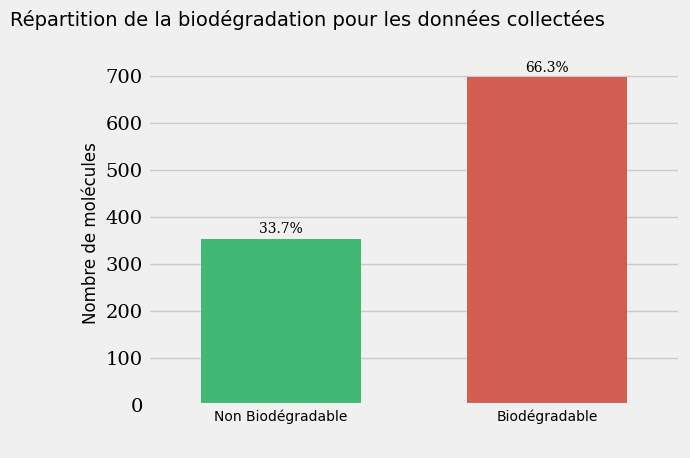

In [12]:
plt.figure()
sns.countplot(data=df, x='Biodegradation_Class', hue='Biodegradation_Class', palette=palette, width=0.6, legend=False) # Ajout de legend=False car hue=x
plt.title('Répartition de la biodégradation pour les données collectées', fontsize=14, pad=25 , x=0.3 ,fontfamily="sans-serif",fontweight ="normal")
plt.xlabel(' ', fontsize=12, fontfamily="sans-serif", fontweight="normal")
plt.ylabel('Nombre de molécules', fontsize=12, fontfamily="sans-serif", fontweight="normal")
plt.xticks(fontsize=10, fontfamily="sans-serif", fontweight="normal", ticks=[0, 1], labels=['Non Biodégradable', 'Biodégradable'])
plt.yticks(fontfamily="serif")

# Ajout des annotations de pourcentage pour la narration
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    # Calcul des pourcentages 66.3% et 33.7% (ajustez l'index p.get_x() si nécessaire)
    percentage = f'{(100 * height / total):.1f}%'
    plt.gca().text(p.get_x() + p.get_width() / 2.,
                   height + 5, #
                   percentage,
                   ha="center", va='bottom', fontsize=10, fontweight='normal',fontfamily="serif")

plt.tight_layout()
plt.show()

Notre variable cible prend 2 valeurs **NRB** et **RB** pour non **biodégradable** et **biodegradable** 66.3% des cas ont fais face a des molécule ayant une structures chimique **non biodégradable** et 33.7% des molécule ayant une structure chimique **biodégradable** soit 698 molécules **BiodégBiodégradables**
et 354 molécules **Non BiodégBiodégradables**

### Analyse multivariée

In [14]:
# df.columns

In [15]:
# for col in ['nHM' ,'F01[N-N]','F04[C-N]', 'NssssC', 'nCb-' ,'nO', 'F03[C-N]', 'nN-N', 'nArNO2', 'nCRX3','nCIR', 'B01[C-Br]', 'B03[C-Cl]', 'N-073',
#        'B04[C-Br]', 'nCrt', 'C-026', 'F02[C-N]', 'nHDon', 'nN', 'nArCOOR', 'nX',
#        'Biodegradation_Class']:
#   print(df[col].value_counts())

In [16]:
cat = ['nHM' ,'F01[N-N]','F04[C-N]', 'NssssC', 'nCb-' ,'nO', 'F03[C-N]', 'nN-N', 'nArNO2', 'nCRX3','nCIR', 'B01[C-Br]', 'B03[C-Cl]', 'N-073',
       'B04[C-Br]', 'nCrt', 'C-026', 'F02[C-N]', 'nHDon', 'nN', 'nArCOOR', 'nX',
       'Biodegradation_Class','F03[C-O]']

rest = df.copy()
for var in cat :
  if var in df.columns :
    rest = rest.drop(var , axis=1)

rest.shape

(1052, 18)

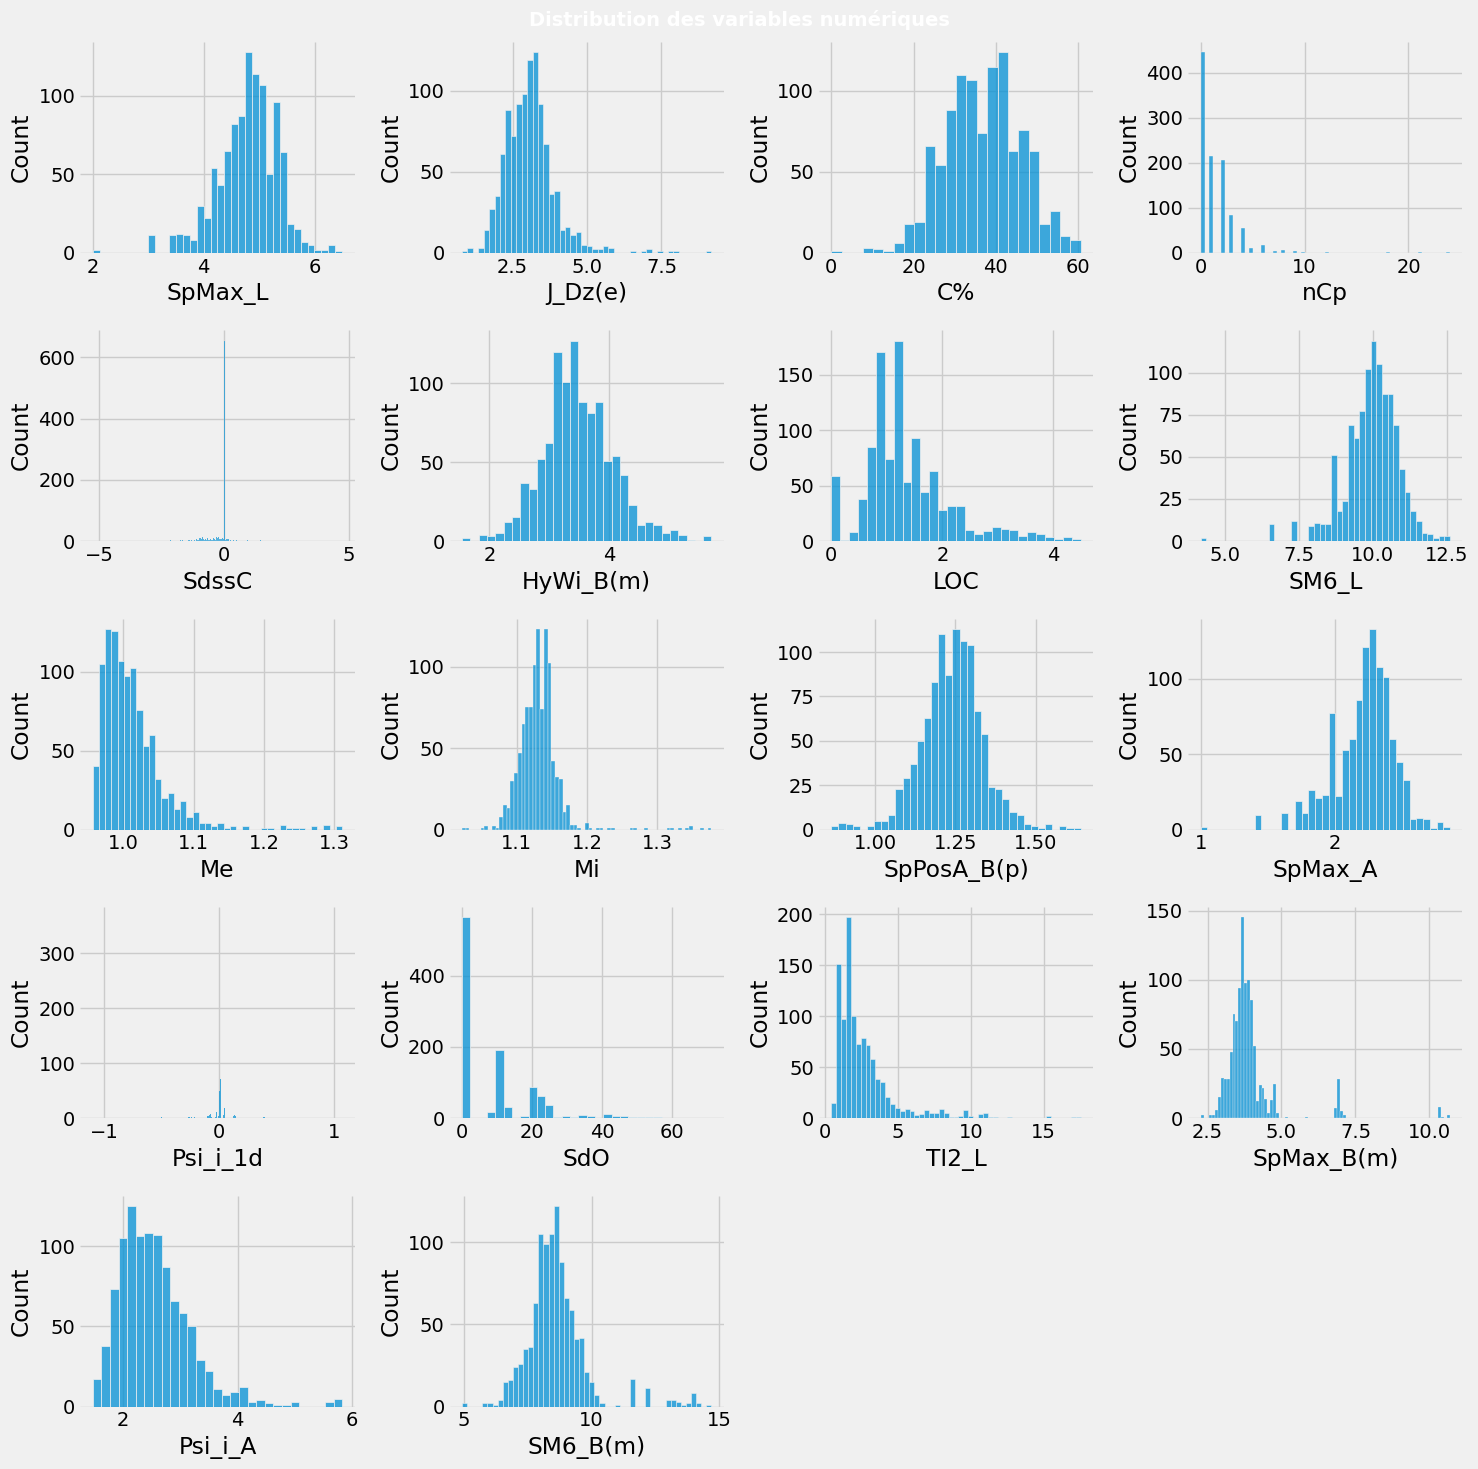

In [35]:
# nclos = 4
n = len(rest.columns)
cols = 4
rows = int(np.ceil(n / cols))

fig , axes = plt.subplots(rows , cols , figsize=(15,rows*3))
axes = axes.flatten() # simplifie l’indexation

for i , v in enumerate(rest.columns):
  sns.histplot(df[v]  , ax = axes[i])
  for spine in axes[i].spines.values():
    spine.set_visible(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution des variables numériques", fontsize=14, color="white", fontweight="bold")
plt.tight_layout()
plt.show()
# plt.tight_layout(

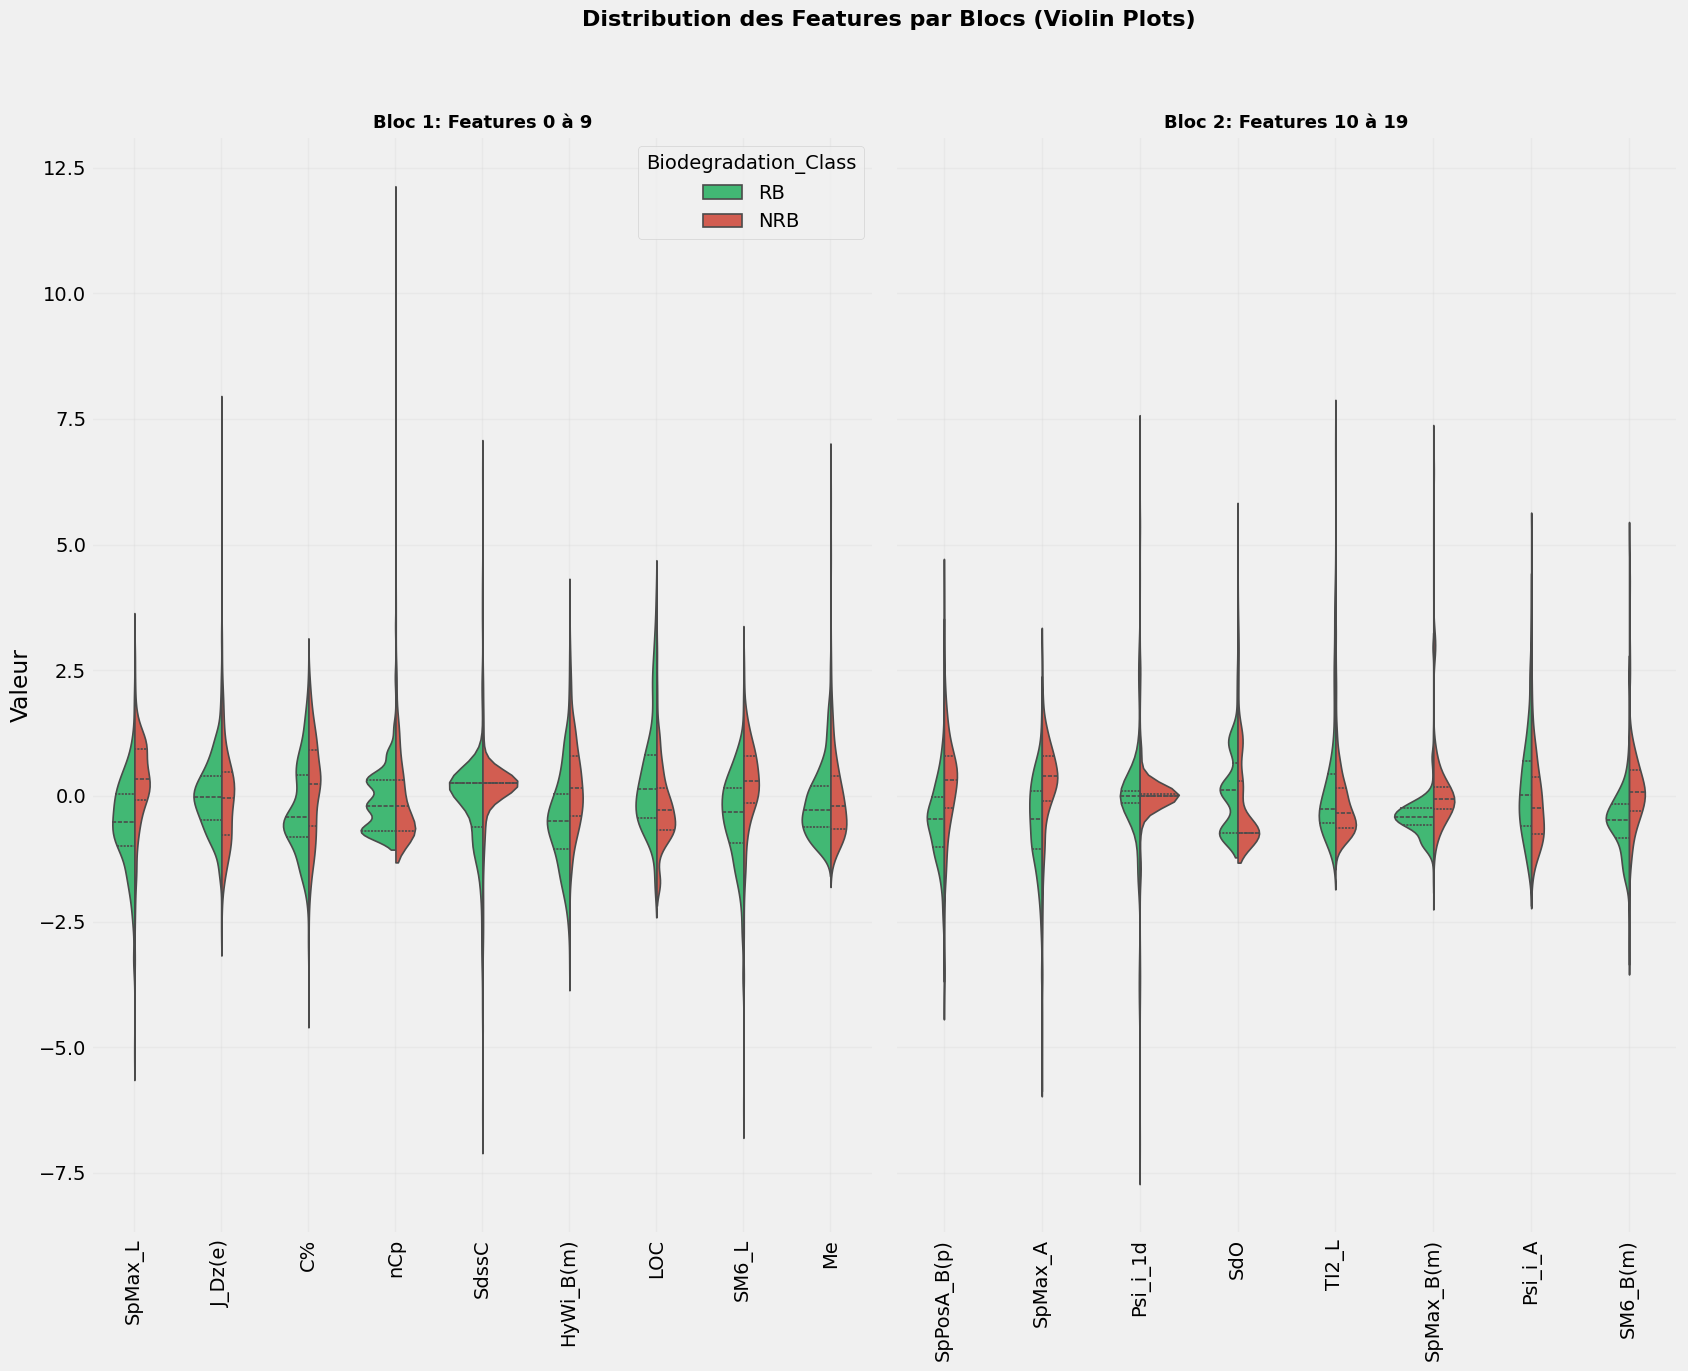

In [18]:

X = rest
y = df['Biodegradation_Class']
st_df = (X-X.mean())/X.std()
blocks = [
    st_df.iloc[:, 0:9],
    st_df.iloc[:, 10:18]

]

# # --- 2️ Fusion et transformation en format long ---
melted_blocks = []
for block in blocks:
    temp_df = pd.concat([block, y], axis=1)
    melt_df = pd.melt(
        temp_df,
        id_vars="Biodegradation_Class",
        var_name="features",
        value_name="value"
    )
    melted_blocks.append(melt_df)


# --- 3️ Création de la figure ---
fig, axes = plt.subplots(1, 2, figsize=(18, 14),sharey=True)
plt.suptitle("Distribution des Features par Blocs (Violin Plots)", fontsize=16, fontweight="bold")

# Palette de couleurs personnalisée
# palette = {"Class0": "#3498db", "Class1": "#e74c3c"} if "Class0" in y["target"].unique() else "Set2"

# --- 4️ Boucle de visualisation ---
for i, (ax, melt_df) in enumerate(zip(axes, melted_blocks), start=1):
    sns.violinplot(
        data=melt_df,
        # showmedians=True,
        x="features",
        y="value",
        hue="Biodegradation_Class",
        split=True,
        inner="quart",
        # gap=0.,
        linewidth=1.2,
        # ls="--",
        palette=palette,

        ax=ax
    )
    ax.set_title(f"Bloc {i}: Features {10*(i-1)} à {10*i - 1}", fontsize=13, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Valeur" if i == 1 else "")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(alpha=0.2)
    if i != 1:
        ax.get_legend().remove()

# --- 5️ Légende globale et ajustement ---
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Target", loc="upper right", fontsize=10)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


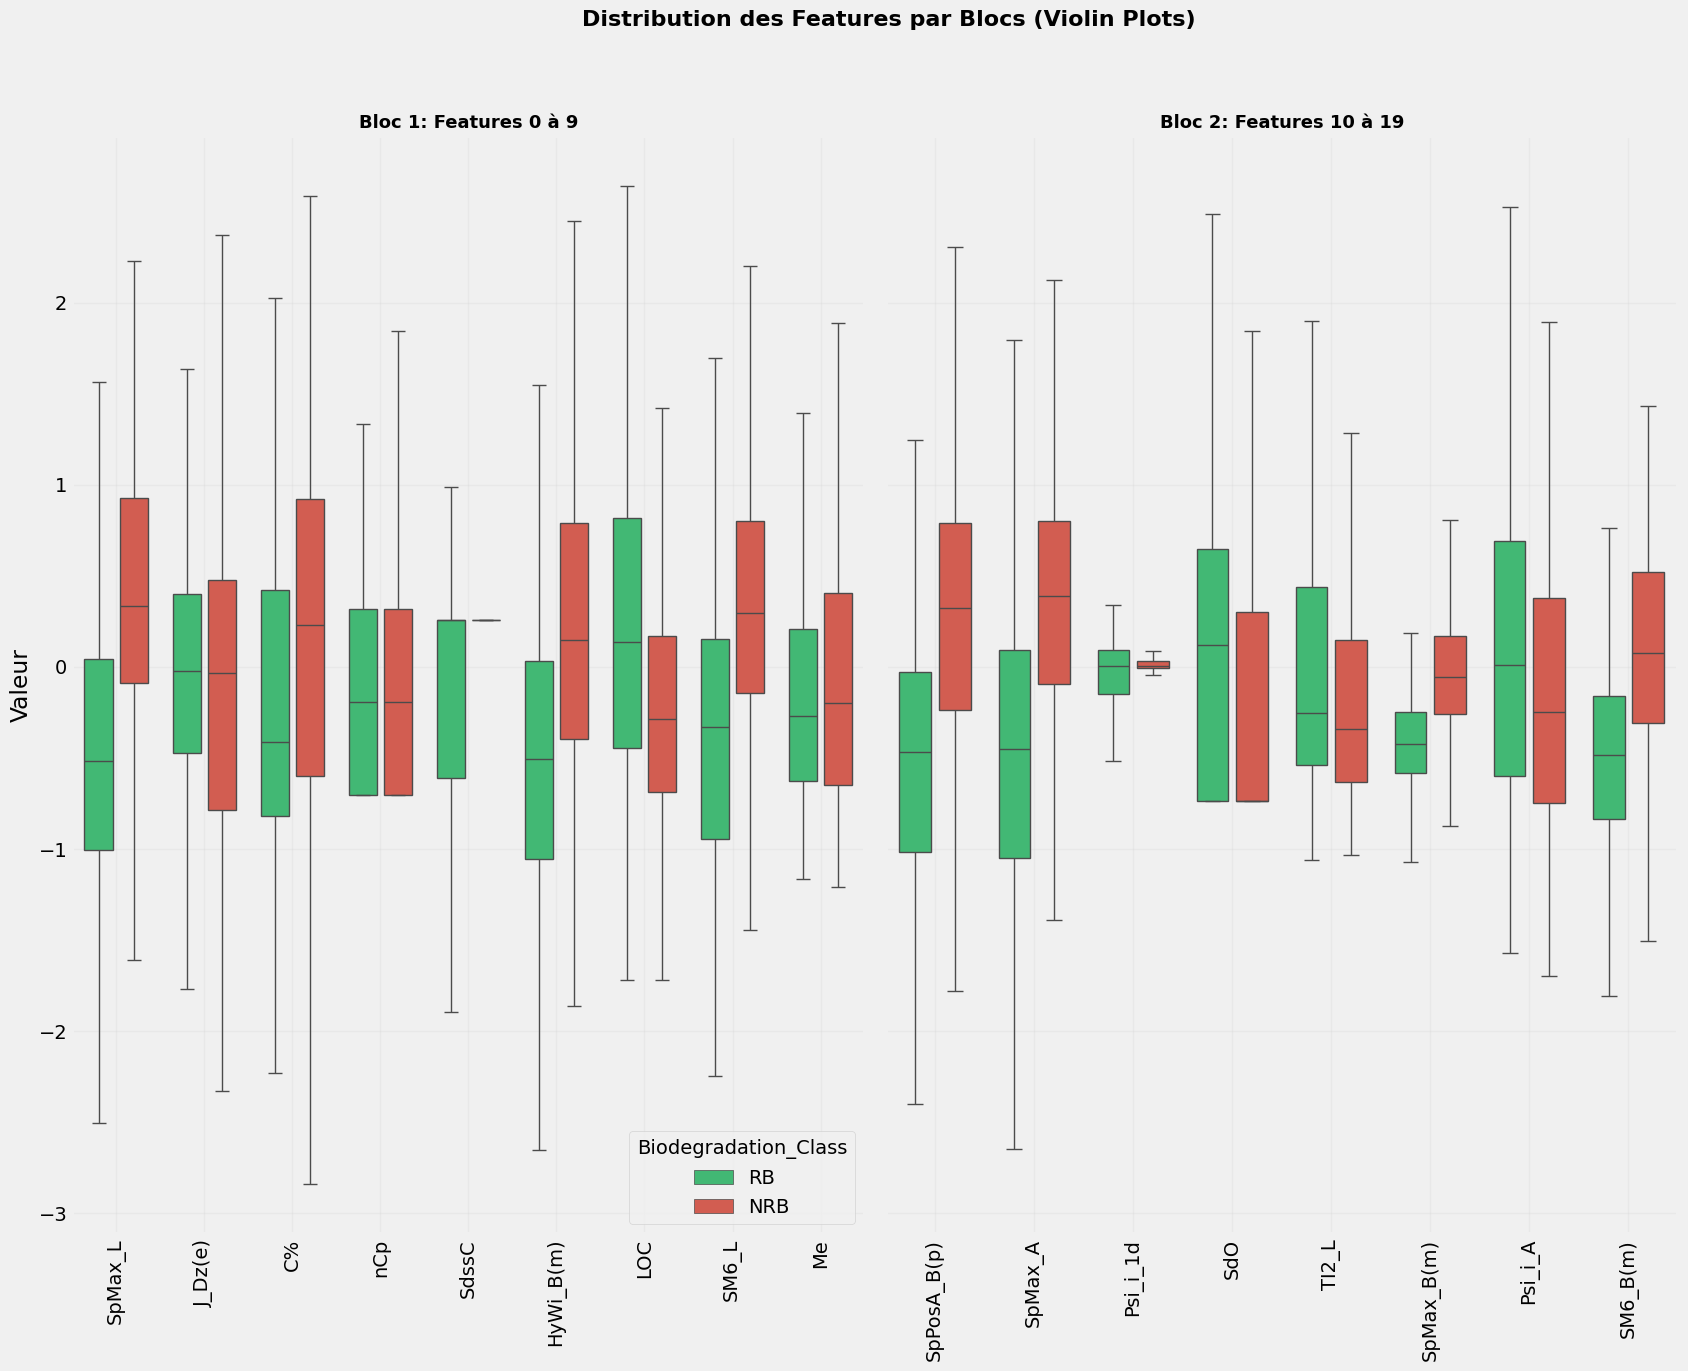

In [19]:

X = rest
y = df['Biodegradation_Class']
st_df = (X-X.mean())/X.std()
blocks = [
    st_df.iloc[:, 0:9],
    st_df.iloc[:, 10:18]

]

# # --- 2️ Fusion et transformation en format long ---
melted_blocks = []
for block in blocks:
    temp_df = pd.concat([block, y], axis=1)
    melt_df = pd.melt(
        temp_df,
        id_vars="Biodegradation_Class",
        var_name="features",
        value_name="value"
    )
    melted_blocks.append(melt_df)


# --- 3️ Création de la figure ---
fig, axes = plt.subplots(1, 2, figsize=(18, 14),sharey=True)
plt.suptitle("Distribution des Features par Blocs (Violin Plots)", fontsize=16, fontweight="bold")

# Palette de couleurs personnalisée
# palette = {"Class0": "#3498db", "Class1": "#e74c3c"} if "Class0" in y["target"].unique() else "Set2"

# --- 4️ Boucle de visualisation ---
for i, (ax, melt_df) in enumerate(zip(axes, melted_blocks), start=1):
    # sns.stripplot(
    #     data=melt_df,
    #     # showmedians=True,
    #     x="features",
    #     y="value",
    #     hue="Biodegradation_Class",
    #     alpha=0.2,
    #     size=5,
    #     # split=True,
    #     # inner="quart",
    #     # # gap=0.,
    #     # linewidth=1.2,
    #     # ls="--",
    #     palette=palette,

    #     ax=ax
    # )
    sns.boxplot(
        data=melt_df,
        # showmedians=True,
        x="features",
        y="value",
        hue="Biodegradation_Class",
        showfliers=False,
        gap=0.2,
        # split=True,
        # inner="quart",
        # # gap=0.,
        # linewidth=1.2,
        # ls="--",
        palette=palette,

        ax=ax
    )
    ax.set_title(f"Bloc {i}: Features {10*(i-1)} à {10*i - 1}", fontsize=13, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Valeur" if i == 1 else "")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(alpha=0.2)
    if i != 1:
        ax.get_legend().remove()

# --- 5️ Légende globale et ajustement ---
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Target", loc="upper right", fontsize=10)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


In [20]:
df.loc[:,rest.columns].join(df['Biodegradation_Class']).groupby('Biodegradation_Class').agg(['mean','std'])

SpMax_L             J_Dz(e)                   C%  \
                          mean       std      mean       std       mean   
Biodegradation_Class                                                      
NRB                   4.935666  0.505100  3.072342  0.925044  38.362034   
RB                    4.478164  0.495227  3.061453  0.602957  34.509040   

                                     nCp               SdssC            ...  \
                           std      mean       std      mean       std  ...   
Biodegradation_Class                                                    ...   
NRB                   9.332989  1.457020  2.261654 -0.136520  0.726821  ...   
RB                    8.189510  1.223164  1.167756 -0.313017  0.829240  ...   

                           SdO                TI2_L           SpMax_B(m)  \
                          mean        std      mean       std       mean   
Biodegradation_Class                                                       
NRB                   8.337307  12.997952  2.410612  1.651425   4.124345   
RB                    9.674833   9.328271  3.180879  2.708975   3.513076   

                                 Psi_i_A            SM6_B(m)            
                           std      mean       std      mean       std  
Biodegradation_Class                                                    
NRB                   1.127979  2.505954  0.635793  8.953170  1.303414  
RB                    0.469806  2.654684  0.639993  7.991701  0.793323  

[2 rows x 36 columns]

### Analyse des distributions des variables discrète (0,1)

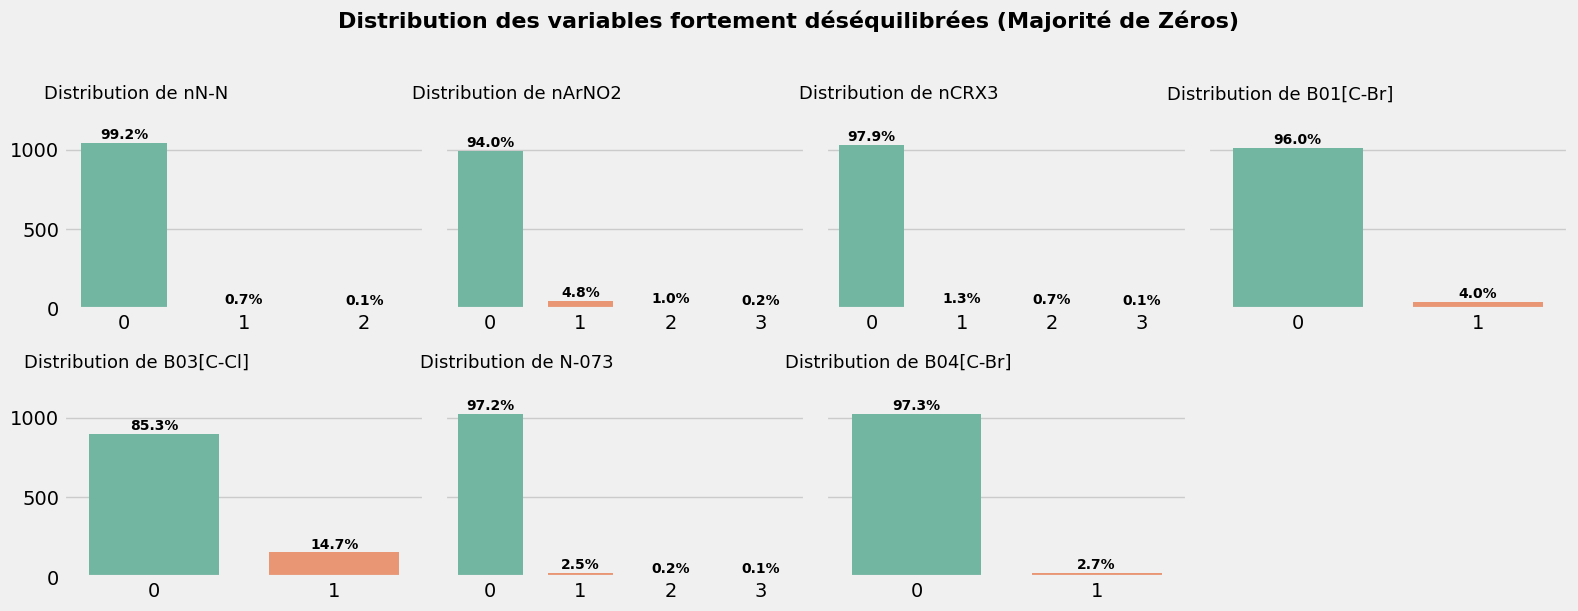

In [21]:
zeros_1 = ['nN-N', 'nArNO2', 'nCRX3','B01[C-Br]', 'B03[C-Cl]', 'N-073','B04[C-Br]']

Discrete_10 = df[cat].copy()
for col in zeros_1 :
  if col in Discrete_10.columns:
    Discrete_10.drop(col, axis=1, inplace=True)

# Discrete_10.shape , df.shape


# nombre de graphiques
n = len(zeros_1)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3), sharey=True)
axes = axes.flatten()  # simplifie l’indexation
total = len(df) # Le total d'observations pour le calcul du pourcentage

for i, v in enumerate(zeros_1):
    if v in df.columns:
        ax = axes[i]
        sns.countplot(data=df, x=v, ax=ax, gap=0.1, palette="Set2")
        ax.set_title(f"Distribution de {v}", fontsize=13, fontweight="normal", fontfamily="sans-serif", x=0.2, pad=25)
        ax.set_xlabel("")
        ax.set_ylabel("")

        # -----------------------------------------------------
        # AJOUT DES POURCENTAGES
        # -----------------------------------------------------
        for p in ax.patches:
            height = p.get_height()
            # Calcul du pourcentage
            percentage = '{:.1f}%'.format(100 * height / total)
            # Positionnement du texte
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + (total * 0.005), # Ajout d'une petite marge au-dessus de la barre
                    percentage,
                    ha="center", va='bottom', fontsize=10, fontweight='bold')
        # -----------------------------------------------------

# Supprimer les cases vides
# i est le dernier index utilisé
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution des variables fortement déséquilibrées (Majorité de Zéros)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# warnings.filterwarnings(category=UserWarning)

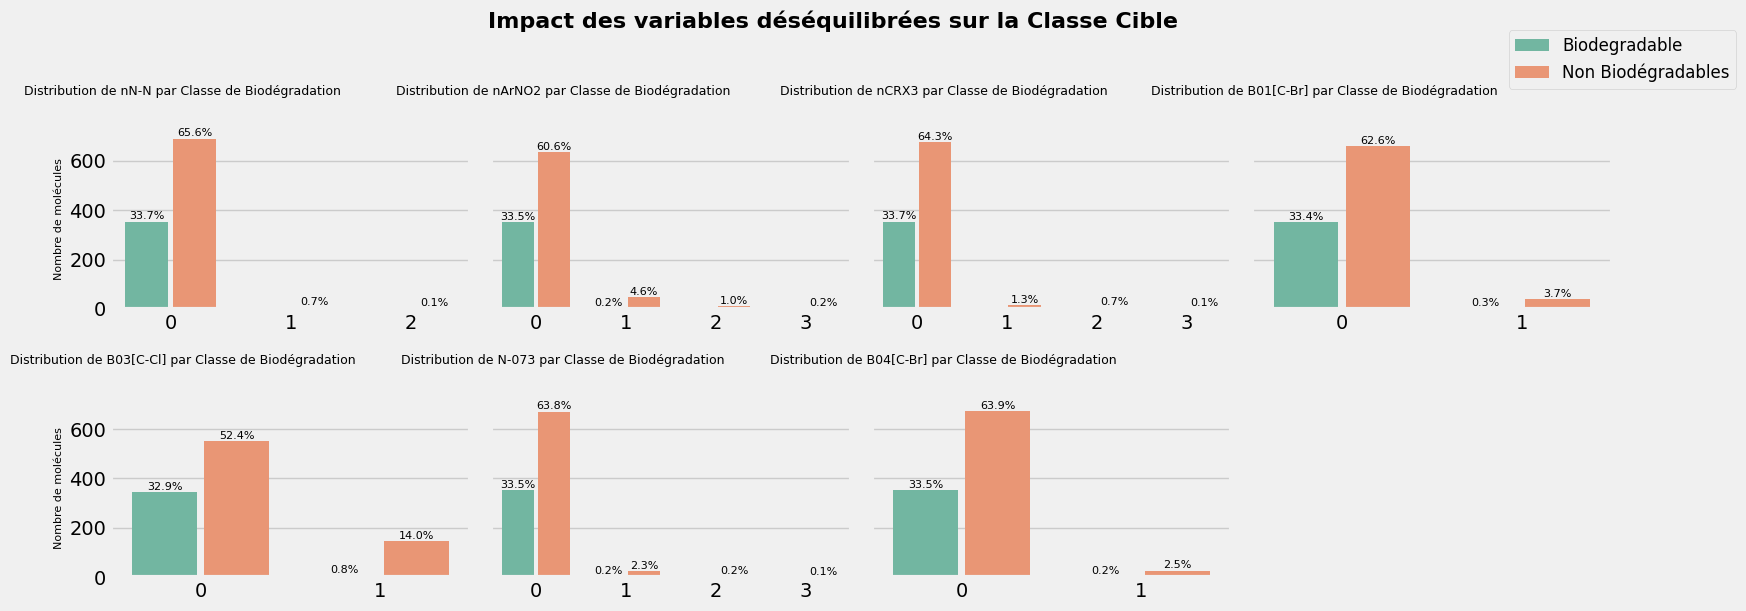

In [47]:

# nombre de graphiques
n = len(zeros_1)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3), sharey=True)
axes = axes.flatten()  # simplifie l’indexation
total = len(df) # Le total d'observations reste la base pour le pourcentage global

# Variables pour stocker les handles et labels de la légende
legend_handles = None
legend_labels = None

for i, v in enumerate(zeros_1):
    if v in df.columns:
        ax = axes[i]

        # AJOUT DE LA VARIABLE CIBLE AVEC HUE
        sns.countplot(data=df, x=v, hue="Biodegradation_Class", ax=ax, gap=0.1, palette="Set2")

        ax.set_title(f"Distribution de {v} par Classe de Biodégradation",
                     fontsize=9,
                     fontweight="normal",
                     fontfamily="sans-serif",
                     x=0.2,
                     pad=25)
        ax.set_xlabel("")
        ax.set_ylabel("Nombre de molécules",fontsize=8)

        # 1. DÉSACTIVER LA LÉGENDE INDIVIDUELLE ET STOCKER LES ÉLÉMENTS
        if i == 0:
            # Récupérer les éléments du premier graphique
            legend_handles, legend_labels = ax.get_legend_handles_labels()

        # Supprimer la légende de l'axe actuel (quel que soit l'index)
        ax.legend().remove()

        # AJOUT DES POURCENTAGES (par rapport au total du DataFrame)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = '{:.1f}%'.format(100 * height / total)

                ax.text(p.get_x() + p.get_width() / 2.,
                        height + (total * 0.001),
                        percentage,
                        ha="center", va='bottom', fontsize=8)

# Supprimer les cases vides
# i est le dernier index utilisé
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 2. AJOUTER LA LÉGENDE GLOBALE À LA FIGURE
if legend_handles and legend_labels:
    fig.legend(legend_handles,
               labels={"Biodegradable" :'RB' , 'Non Biodégradables':'NRB'},
               title='',
               fontsize=12,
               loc='upper right', # Positionnement de la légende globale
               bbox_to_anchor=(1.07, 1.0)) # Ajustement pour qu'elle soit en dehors du graphique

plt.suptitle("Impact des variables déséquilibrées sur la Classe Cible", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

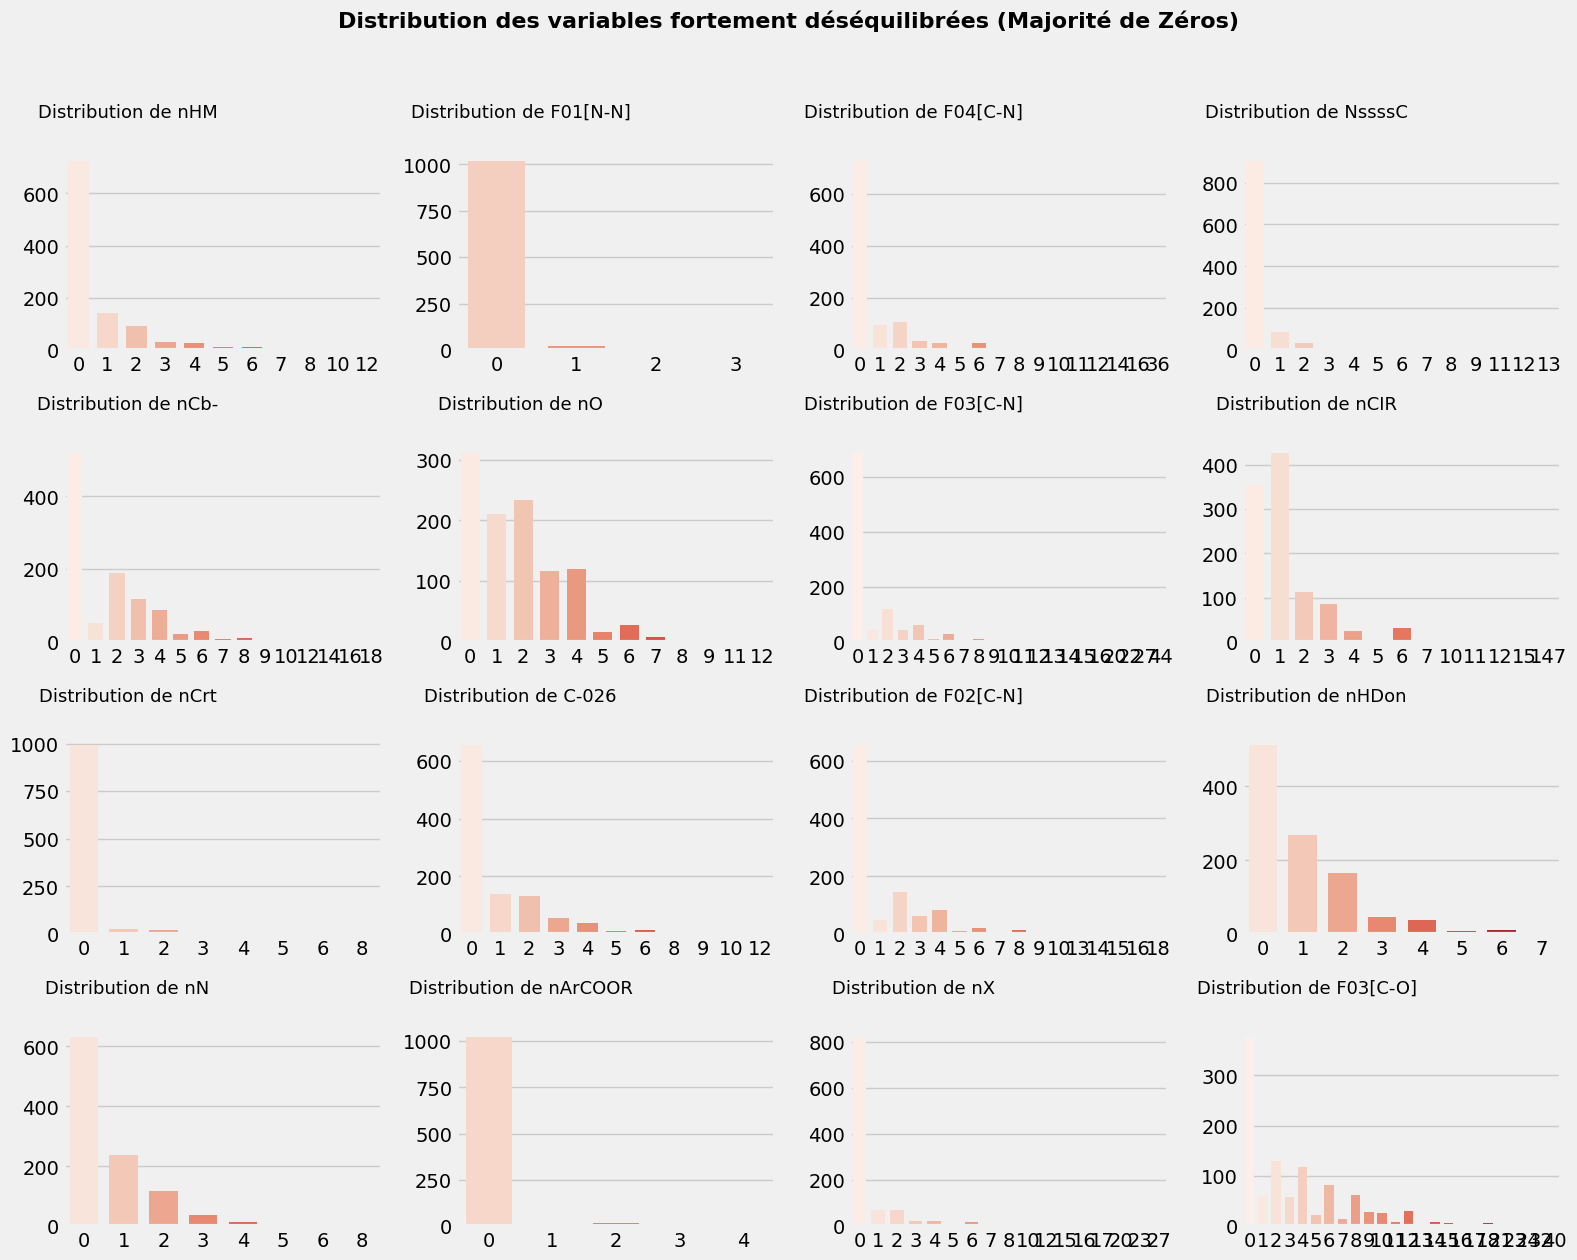

In [43]:
vars_discrete_10 = Discrete_10.columns[Discrete_10.columns!="Biodegradation_Class"]

# df[vars_discrete_10].groupby('Biodegradation_Classl
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten()  # simplifie l’indexation
total = len(df) # Le total d'observations pour le calcul du pourcentage

for i, v in enumerate(vars_discrete_10):
    if v in df.columns:
        ax = axes[i]
        sns.countplot(data=df, x=v, ax=ax, gap=0.1, palette="Reds")
        ax.set_title(f"Distribution de {v}", fontsize=13, fontweight="normal", fontfamily="sans-serif", x=0.2, pad=25)
        ax.set_xlabel("")
        ax.set_ylabel("")




# Supprimer les cases vides
# i est le dernier index utilisé
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Distribution des variables fortement déséquilibrées (Majorité de Zéros)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# warnings.filterwarnings(category=UserWarning)

Observation sur la Distribution et les Modalités

Nous observons que la majorité des variables présentent une forte concentration de leurs valeurs à zéro (distribution dite « zéro-inflation » ou « zero-inflated »).


### Matrice de corrélation des variables continue

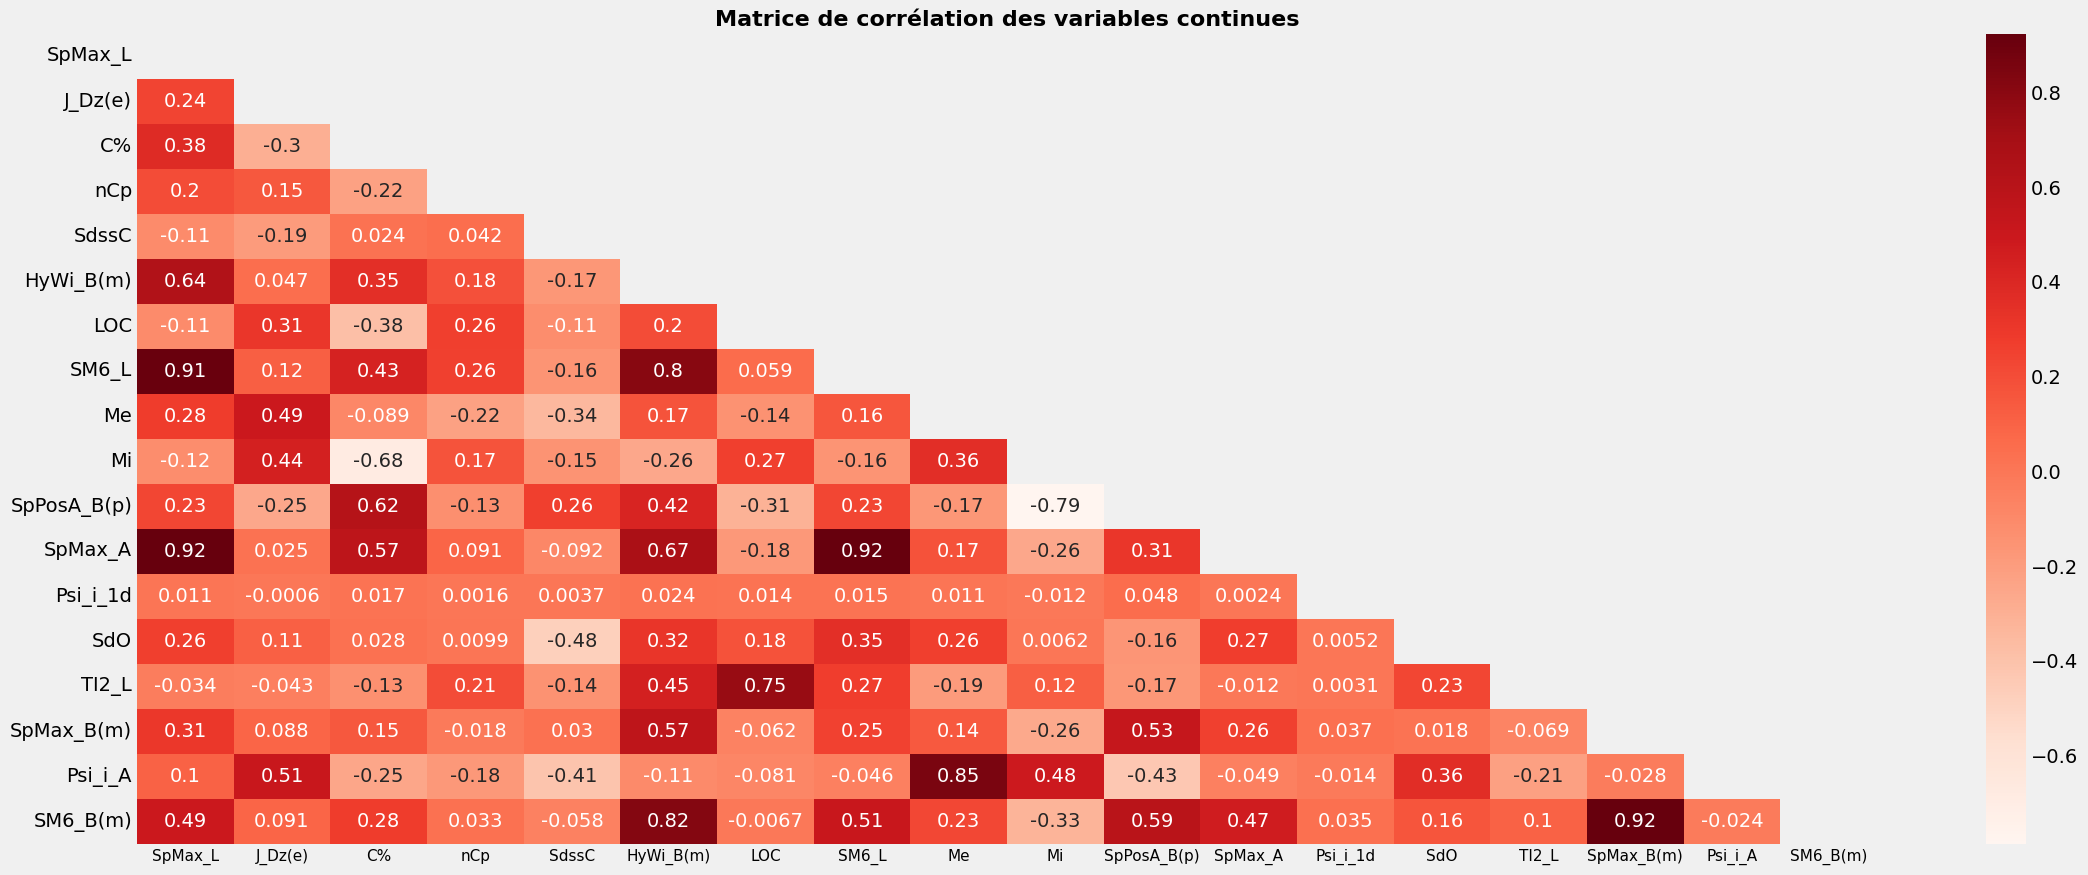

In [24]:
Corr_df = rest.corr()
mask = np.triu(Corr_df)
plt.figure(figsize=(25,10))
sns.heatmap(Corr_df, annot=True, mask=mask,cmap="Reds")
plt.title("Matrice de corrélation des variables continues", fontsize=16, fontweight="bold", y=1.0)
plt.grid(False)
plt.xticks(rotation=0,fontsize=11)
plt.show()

On note que certaines variables sont fortement corrélé ensemble avec un corrélation supérieur a 85%  

`SmMax_A vs SpMax_l` -> **0.92**

`SpMax_L vs SM6_L`    -> **0.91**

`SpMAx_A vs SM6_L`   -> **0.92**

`Me vs Psi_i_A`      -> **0.85**

`SpMax_N vs SM6_B`   -> **0.92**

### Test d'hypothèse

Dans cette partie nous allons essayer de répondre a deux question essentielle pour la suite

* 1 Les distributions des **caractéristiques continue** sont-elles **différentes** en fonction de la variable cible de manière **significative** ?

* 2 Les variabless discrete sont elles distribué de facons a etre differente en fonction de la sortie (NRB / RB ) ?

Ont sait que la distribution n'est pas normal pour toute les variables alors nous allons utiliser le test de Mann-withney

In [25]:
df['Biodegradation_Class'].unique()

array(['RB', 'NRB'], dtype=object)

In [26]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Supposons que 'df' est votre DataFrame.
# La liste 'rest.columns' contient les noms des colonnes numériques à analyser (les prédicteurs).

P_THRESHOLD = 0.05 # Seuil de signification

print(f"--- Variables NON-SIGNIFICATIVES (P > {P_THRESHOLD}) ---")

for col in rest.columns:
    if col in df.columns:

        # 1. Séparer la colonne numérique ('col') en deux groupes basés sur la classe
        group_RB = df[df['Biodegradation_Class'] == 'RB'][col].dropna() # Utiliser .dropna() pour la robustesse
        group_NRB = df[df['Biodegradation_Class'] == 'NRB'][col].dropna()

        # 2. Vérifier si les groupes contiennent assez de données pour le test
        if len(group_RB) > 5 and len(group_NRB) > 5:

            # 3. Appliquer le test de Mann-Whitney U
            stat, p = mannwhitneyu(x=group_RB, y=group_NRB, alternative='two-sided')

            # 4. Afficher le résultat si la P-valeur est SUPÉRIEURE au seuil
            if p > P_THRESHOLD:
                # Cette variable est NON-SIGNIFICATIVE : elle est un faible prédicteur
                print(f"Variable '{col}':")
                print(f"  U-Statistique = {stat:.2f}, P-valeur = {p:.4f} (Non-Significatif)")

            # (Optionnel) Vous pouvez imprimer les variables significatives séparément
            # else:
            #     print(f"Variable '{col}' est SIGNIFICATIVE (P <= {P_THRESHOLD}) et est écartée de cette liste.")

        else:
            # Gestion des groupes trop petits pour le test
            print(f"--- ATTENTION : Test sauté pour '{col}' ---")
            print(f"  Taille des groupes insuffisante : RB={len(group_RB)}, NRB={len(group_NRB)}")

--- Variables NON-SIGNIFICATIVES (P > 0.05) ---
Variable 'J_Dz(e)':
  U-Statistique = 129548.00, P-valeur = 0.1974 (Non-Significatif)
Variable 'nCp':
  U-Statistique = 130187.00, P-valeur = 0.1343 (Non-Significatif)
Variable 'Me':
  U-Statistique = 116528.00, P-valeur = 0.1318 (Non-Significatif)
Variable 'Psi_i_1d':
  U-Statistique = 123504.00, P-valeur = 0.9928 (Non-Significatif)


Le test de mann withney nous informe que les variables :`J_DZ(e) , nCp , Me & Psi_i_id` ne sont pas discriminant par rapport a la variable cible

In [52]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import numpy as np

def perform_categorical_test(data_frame, variable_name, target_name):
    """Effectue un test statistique (Chi-deux ou Fisher) et retourne le P-value."""

    # Créer la table de contingence
    contingency_table = pd.crosstab(data_frame[variable_name], data_frame[target_name])

    # Vérifier si la variable a plus d'une modalité non nulle
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        return 'N/A (Une seule modalité ou classe cible)'

    # Choisir le Test Statistique
    if contingency_table.shape == (2, 2):
        odds_ratio, p_value = fisher_exact(contingency_table)
        test_name = "Fisher"
    else:
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        test_name = "Chi-deux"

    return p_value, test_name

# --- 2. Application de la Fonction à Toutes les Variables ---

results = {}
target_col = 'Biodegradation_Class'

# Définir la liste des variables explicatives (toutes les colonnes sauf la Cible)
feature_cols = [col for col in zeros_1 if col != target_col]

print("## 📊 Résultats des Tests d'Indépendance Catégorielle (vs. Cible)")
print("-" * 60)

for variable in feature_cols:

    test_result = perform_categorical_test(df, variable, target_col)

    if isinstance(test_result, tuple):
        p_value, test_name = test_result

        # Interprétation de la P-value
        if p_value < 0.05:
            significance = "**Significatif (Rejet H0)**"
        else:
            significance = "Non Significatif (Non-rejet H0)"

        print(f"| {variable:11} | Test: {test_name:6} | P-value: {p_value:.4f} | {significance}")
    else:
        print(f"| {variable:11} | Résultat: {test_result}")

print("-" * 60)
# Optionnel: Afficher le résumé dans un DataFrame
results_df = pd.DataFrame(results).T.rename(columns={0: 'P-value', 1: 'Test', 2: 'Conclusion'})
# print("\nRésumé des Résultats:")
# print(results_df)

## 📊 Résultats des Tests d'Indépendance Catégorielle (vs. Cible)
------------------------------------------------------------
| nN-N        | Test: Chi-deux | P-value: 0.1295 | Non Significatif (Non-rejet H0)
| nArNO2      | Test: Chi-deux | P-value: 0.0000 | **Significatif (Rejet H0)**
| nCRX3       | Test: Chi-deux | P-value: 0.0098 | **Significatif (Rejet H0)**
| B01[C-Br]   | Test: Fisher | P-value: 0.0001 | **Significatif (Rejet H0)**
| B03[C-Cl]   | Test: Fisher | P-value: 0.0000 | **Significatif (Rejet H0)**
| N-073       | Test: Chi-deux | P-value: 0.0220 | **Significatif (Rejet H0)**
| B04[C-Br]   | Test: Fisher | P-value: 0.0018 | **Significatif (Rejet H0)**
------------------------------------------------------------
